<a href="https://colab.research.google.com/github/HyunMooKim/AI-Data/blob/main/DAB_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Me
**서울시에 공유 양우산 서비스를 제공하기 위한 데이터 분석.<br>**
서울시 버스 정류장, 지하철 역, 각종 시설들을 수요지로, 지하철 역을 공급지로 하여<br>
MCLP(Maximal covering location problem) 알고리즘을 이용해 가장 효율적으로 많은 유동인구와 수요지를 커버하도록 공급지를 선택하는 과정이다.

# 최종코드

## 데이터 불러오기

입지 선정입니다.

2022 버스. 지하철 유동인구 전처리는 다른 링크에서 진행했습니다.
https://colab.research.google.com/drive/16RIw9shg_5dZ-FdU1zanqMzP3IFndSiq?hl=ko#scrollTo=nEDhOcOc2HXD&uniqifier=3



데이터 전처리를 하면서 느낀점:(숨겨진 ','와 띄어쓰기, 뒤바뀐 위경도, 통합되지 않은 데이터 column등 우여곡절이 있었다.)

1. 프로젝트 시작 단계라면, 최대한 쪼개서 보관하라.
ex) 구별로 합치지 말고, 구 정보를 추가해라 나중에 필요할 수 있다.
     승하차로 합치지 말고, 둘 다 저장해라.

2. 취합할 데이터라면, 형식을 미리 정해라.
  type, name, region, log, lat 등 필수적인 column의 이름, 데이터값 형태, 가중치
등 나중에 바꾸려면 골치 아프다. 영어로 하는게 좋다.  kaggle에선 인식이 안 될 수 있다.

3. 방법 설정에 더 오랜 시간을 투자하라.
   어영부영 회의해서 시작하면 결국 돌아오게 되어있다.

In [ ]:
!pip install pulp
from pulp import LpProblem, LpMaximize, LpVariable, lpSum

In [ ]:
import pandas as pd

bus_rain = pd.read_csv('버스_rain.csv', encoding='cp949')
bus_sun = pd.read_csv('버스_sun.csv', encoding='cp949')
subway_rain = pd.read_csv('지하철_rain.csv',encoding='cp949')
subway_sun = pd.read_csv('지하철_sun.csv',encoding='cp949')
facilities = pd.read_csv('시설들.csv', encoding='cp949')

## HyperParameter

weight, radius, number of points

In [ ]:
w_facility = 1  # 공원, 대형시설, 관광지, 대학 가중치
w_return = 2 # 거주시설 가중치
w_population_rain = 1  # 유동인구(우산) 가중치
w_population_sun = 06 # 유동인구(양산) 가중치
radius= 1000 # m 단위



각각 point_num 만큼 돌린다.

그리고 cover percentage에 가중치를 매기고 이를 다 합하여 sort.

그렇게 정해진 순위에서 50부터 10개씩 추가하며 각 단계 확인



## 사전준비

In [ ]:
from geopy import distance
import pandas as pd
import numpy as np


def MCLP_Score(df_demand, df_supply, p, radius):

    dist_matrix = np.zeros((len(df_demand), len(df_supply)))
    for i in range(len(df_demand)):
        for j in range(len(df_supply)):
            loc1 = (df_demand.loc[i,'y'], df_demand.loc[i,'x'])
            loc2 = (df_supply.loc[j,'y'], df_supply.loc[j,'x'])
            dist_matrix[i][j] = distance.distance(loc1, loc2).meters

    # 후보지 중에서 p개 선택
    possible_sites = [LpVariable('x'+str(i), cat='Binary') for i in range(len(df_supply))]
    # 각 수요 지점이 커버되었는지 여부 (1=커버됨, 0=커버되지 않음)
    demand_covered = [LpVariable('y'+str(i), cat='Binary') for i in range(len(df_demand))]
    prob = LpProblem("MCLP", sense=LpMaximize)
    # 목적함수: 커버된 score 최대화
    prob += lpSum(demand_covered[i]*df_demand.loc[i,'score'] for i in range(len(df_demand)))
    # 제약조건1: 선택된 사이트의 개수는 p개
    prob += lpSum(possible_sites) == p
    # 제약조건2: 각 수요 지점은 반경 내의 선택된 사이트에 의해 커버되어야 함
    for i in range(len(df_demand)):
      prob += lpSum(possible_sites[j] for j in np.where(dist_matrix[i]<=radius)[0]) >= demand_covered[i]
    prob.solve()
    selected_idx = [i for i in range(len(possible_sites)) if possible_sites[i].varValue > 0]

    # Calculate total score
    total_score = sum(df_demand.loc[i,'score'] * demand_covered[i].varValue for i in range(len(df_demand)))


    selected_supply = df_supply.iloc[selected_idx]

    return total_score, selected_supply




#우산 대여
####### 유동인구 범위 설정 #################################################
##우산
time_from = 10
time_to = 23
#버스
tmp1 =  [f"{i}시하차총승객수" for i in range(time_from, time_to)] # 시간대
tmp2 = [f"{i}시승차총승객수" for i in range(time_from, time_to)]
bus_rain_rental = ['00시승차총승객수', '00시하차총승객수', '1시승차총승객수', '1시하차총승객수', '2시승차총승객수',
       '2시하차총승객수', '3시승차총승객수', '3시하차총승객수', '4시승차총승객수', '4시하차총승객수', '5시승차총승객수',
       '5시하차총승객수', '6시승차총승객수', '6시하차총승객수', '7시승차총승객수', '7시하차총승객수', '8시승차총승객수',
       '8시하차총승객수', '9시승차총승객수', '9시하차총승객수', '10시승차총승객수', '10시하차총승객수',
       '11시승차총승객수', '11시하차총승객수', '12시승차총승객수', '12시하차총승객수', '13시승차총승객수',
       '13시하차총승객수', '14시승차총승객수', '14시하차총승객수', '15시승차총승객수', '15시하차총승객수',
       '16시승차총승객수', '16시하차총승객수', '17시승차총승객수', '17시하차총승객수', '18시승차총승객수',
       '18시하차총승객수', '19시승차총승객수', '19시하차총승객수', '20시승차총승객수', '20시하차총승객수',
       '21시승차총승객수', '21시하차총승객수', '22시승차총승객수', '22시하차총승객수', '23시승차총승객수',
       '23시하차총승객수' ]
#지하철
tmp1 = [f"{i:02d}-{i+1:02d}시간대_하차" for i in range(time_from, time_to)]
tmp2 = [f"{i:02d}-{i+1:02d}시간대_승차" for i in range(time_from, time_to)]
subway_rain_rental = ['06시이전_승차', '06시이전_하차', '06-07시간대_승차',
       '06-07시간대_하차', '07-08시간대_승차', '07-08시간대_하차', '08-09시간대_승차',
       '08-09시간대_하차', '09-10시간대_승차', '09-10시간대_하차', '10-11시간대_승차',
       '10-11시간대_하차', '11-12시간대_승차', '11-12시간대_하차', '12-13시간대_승차',
       '12-13시간대_하차', '13-14시간대_승차', '13-14시간대_하차', '14-15시간대_승차',
       '14-15시간대_하차', '15-16시간대_승차', '15-16시간대_하차', '16-17시간대_승차',
       '16-17시간대_하차', '17-18시간대_승차', '17-18시간대_하차', '18-19시간대_승차',
       '18-19시간대_하차', '19-20시간대_승차', '19-20시간대_하차', '20-21시간대_승차',
       '20-21시간대_하차', '21-22시간대_승차', '21-22시간대_하차', '22-23시간대_승차',
       '22-23시간대_하차', '23-24시간대_승차', '23-24시간대_하차', '24시이후_승차', '24시이후_하차']
###########################################################################
df_bus = pd.DataFrame()

df_bus['type'] = ['bus'] * len(bus_rain)  # set all rows to "bus station"
df_bus['region'] = bus_rain['region']
df_bus['name'] = bus_rain['name']
df_bus['population'] = bus_rain[bus_rain_rental].sum(axis=1)
df_bus['x'] = bus_rain['x']
df_bus['y'] = bus_rain['y']
df_bus['address'] = bus_rain['address']

df_subway = pd.DataFrame()

df_subway['type'] = ['subway'] * len(subway_rain)  # set all rows to "bus station"
df_subway['region'] = subway_rain['region']
df_subway['name'] = subway_rain['name']
df_subway['population'] = subway_rain[subway_rain_rental].sum(axis=1)
df_subway['x'] = subway_rain['x']
df_subway['y'] = subway_rain['y']
df_subway['address'] = subway_rain['address']

df_demand = pd.concat([df_bus, df_subway], ignore_index=True)
df_demand['type2'] = 'rain'
df_demand = df_demand[['type','type2','region','name','x','y','population']]

supply_rain =df_subway
demand_rain = df_demand


# 6,7,8,9월 12시~18시 유동인구
####### 유동인구 범위 설정 #################################################
#버스
time_from = 10
time_to = 16
tmp1 =  [f"{i}시하차총승객수" for i in range(time_from, time_to)] # 시간대
tmp2 = [f"{i}시승차총승객수" for i in range(time_from, time_to)]
bus_sun_rental = tmp1 + tmp2
#지하철
tmp1 = [f"{i:02d}-{i+1:02d}시간대_하차" for i in range(time_from, time_to)]
tmp2 = [f"{i:02d}-{i+1:02d}시간대_승차" for i in range(time_from, time_to)]
subway_sun_rental = tmp1 + tmp2

###########################################################################
df_bus = pd.DataFrame()

df_bus['type'] = ['bus'] * len(bus_rain)  # set all rows to "bus station"
df_bus['region'] = bus_rain['region']
df_bus['name'] = bus_rain['name']
df_bus['population'] = bus_rain[bus_sun_rental].sum(axis=1)
df_bus['x'] = bus_rain['x']
df_bus['y'] = bus_rain['y']
df_bus['address'] = bus_rain['address']

df_subway = pd.DataFrame()

df_subway['type'] = ['subway'] * len(subway_rain)  # set all rows to "bus station"
df_subway['region'] = subway_rain['region']
df_subway['name'] = subway_rain['name']
df_subway['population'] = subway_rain[subway_sun_rental].sum(axis=1)
df_subway['x'] = subway_rain['x']
df_subway['y'] = subway_rain['y']
df_subway['address'] = subway_rain['address']

df_demand = pd.concat([df_bus, df_subway], ignore_index=True)
df_demand['type2'] = 'sun'
df_demand = df_demand[['type','type2','region','name','x','y','population']]


supply_sun = df_subway
demand_sun = df_demand




### 전부 score

df_facility = facilities[facilities['type'] != '주거지']
df_living = facilities[facilities['type'] == '주거지']

total_population_sun = demand_sun['population'].sum()
demand_sun['score'] = (demand_sun['population'] / total_population_sun) * 100 * w_population_sun

total_population_rain = demand_rain['population'].sum()
demand_rain['score'] = (demand_rain['population'] / total_population_rain) * 100 * w_population_rain

# For df_facility DataFrame
total_rows_facility = len(df_facility)
df_facility['score'] = (1 / total_rows_facility) * 100 * w_facility

# For df_living DataFrame
total_rows_living = len(df_living)
df_living['score'] = (1 / total_rows_living) * 100 * w_return

concatenated_df = pd.concat([df_living, df_facility, demand_rain, demand_sun], axis=0, ignore_index=True)
concatenated_df

<ipython-input-9-0430ddb6cc2b>:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_facility['score'] = (1 / total_rows_facility) * 100 * w_facility
<ipython-input-9-0430ddb6cc2b>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_living['score'] = (1 / total_rows_living) * 100 * w_return


,type,name,x,y,address,region,score,type2,population
0,주거지,우리유앤미,126.959639,37.500668,서울특별시 동작구 서달로 83,동작구,0.073611,NaN,NaN
1,주거지,송파파인타운13단지,127.129179,37.476897,서울특별시 송파구 송파대로8길 10,송파구,0.073611,NaN,NaN
2,주거지,오금현대백조(임대),127.128775,37.508906,서울특별시 송파구 양재대로72길 20,송파구,0.073611,NaN,NaN
3,주거지,개봉건영,126.840675,37.501162,서울특별시 구로구 고척로21나길 85-6,구로구,0.073611,NaN,NaN
4,주거지,월계동원베네스트,127.058220,37.631732,서울특별시 노원구 월계로53길 21,노원구,0.073611,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16811,subway,혜화,127.001844,37.582336,NaN,종로구,0.862653,sun,8.161924e+06
16812,subway,홍대입구,126.926715,37.557438,NaN,마포구,1.429040,sun,1.352075e+07
16813,subway,홍제,126.943736,37.589066,NaN,서대문구,0.363304,sun,3.437369e+06
16814,subway,화곡,126.840461,37.541513,NaN,강서구,0.477262,sun,4.515580e+06


## 한계효용

Colab과 Kaggle에서 나누어서 진행

============================top 70==========================
70 score:  285.46421048524707
============================top 75==========================
75 score:  294.90192686036534
============================top 80==========================
80 score:  303.86238519083565
============================top 85==========================
85 score:  311.9519228142341
============================top 90==========================
90 score:  318.9420775107512
============================top 95==========================
95 score:  324.1198899066886
============================top 100==========================
100 score:  328.18810334805244
============================top 105==========================
105 score:  331.6833838121408
============================top 110==========================
110 score:  334.2440422887894
============================top 115==========================
115 score:  336.40773659106475
============================top 120==========================
120 score:  338.020109909

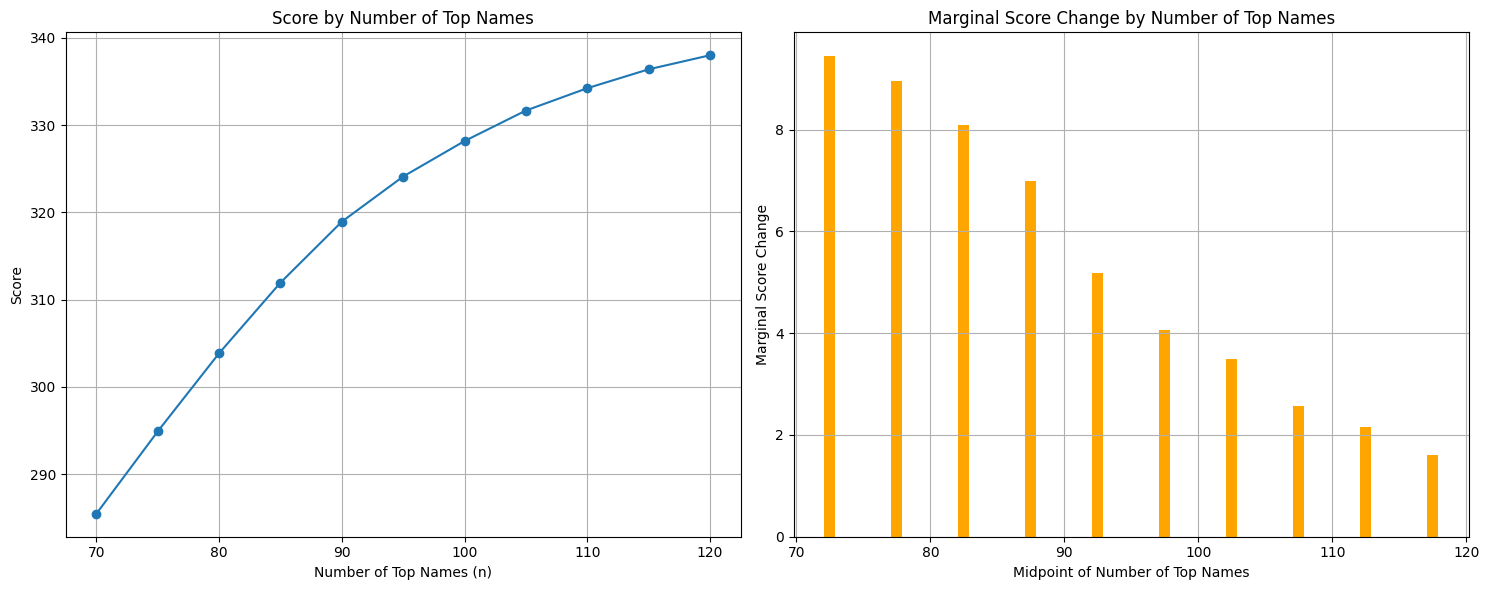

In [ ]:
# We Only Need

scores = []
for n in [70,75,80,85,90,95,100,105,110,115,120]:
  print(f'============================top {n}==========================')
  score, seleceted_points = MCLP_Score(df_demand=concatenated_df,
                                  df_supply=supply_rain,
                                  p=n,
                                  radius=radius)
  print(n, 'score: ', score)
  scores.append( (n,score) )

import matplotlib.pyplot as plt
x, y = zip(*scores)
marginal_scores = [y[i+1] - y[i] for i in range(len(y)-1)]
x_marginal = [(x[i+1] + x[i]) / 2 for i in range(len(x)-1)]
# Plot original scores
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y, marker='o')
plt.xlabel('Number of Top Names (n)')
plt.ylabel('Score')
plt.title('Score by Number of Top Names')
plt.grid(True)

# Plot marginal score change
plt.subplot(1, 2, 2)
plt.bar(x_marginal, marginal_scores, color='orange')
plt.xlabel('Midpoint of Number of Top Names')
plt.ylabel('Marginal Score Change')
plt.title('Marginal Score Change by Number of Top Names')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

시각화

코랩, 캐글 합친것 시각화

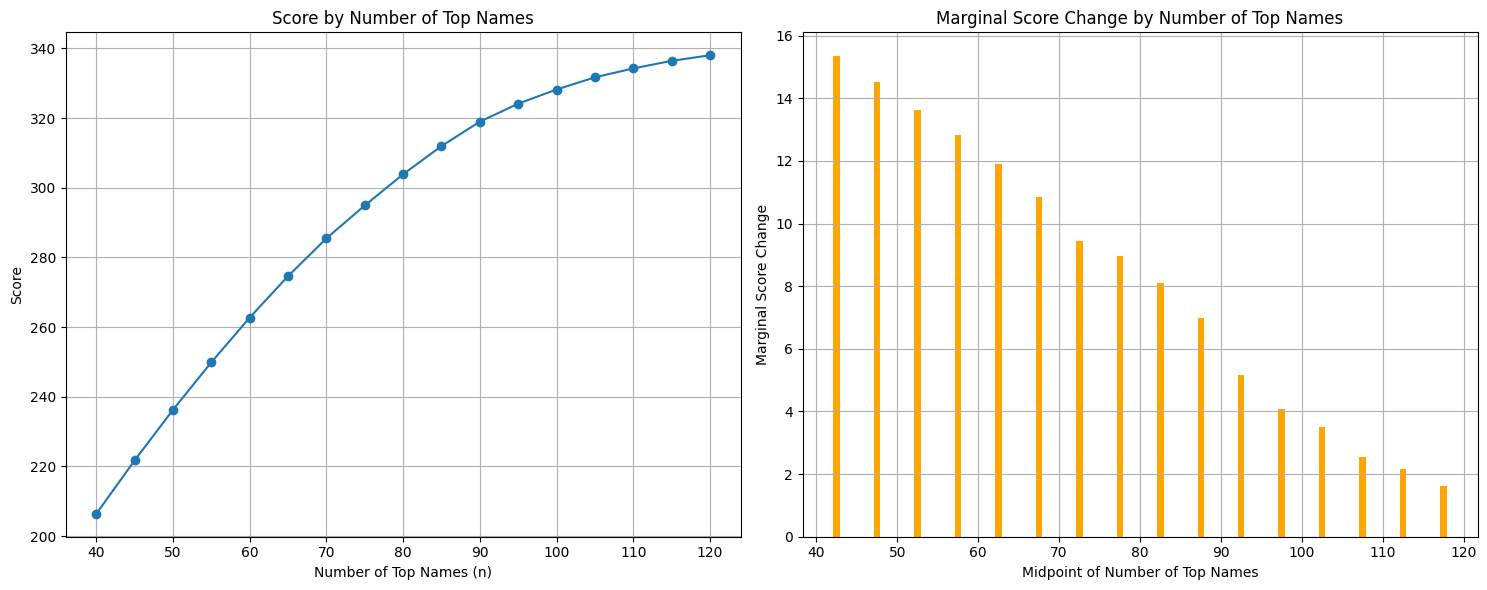

In [ ]:
df = pd.read_csv('MU.csv')
df = df[df['n'] % 5 == 0].reset_index()
import matplotlib.pyplot as plt
x = df['n']
y = df['score']
marginal_scores = [y[i+1] - y[i] for i in range(len(y)-1)]
x_marginal = [(x[i+1] + x[i]) / 2 for i in range(len(x)-1)]
# Plot original scores
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y, marker='o')
plt.xlabel('Number of Top Names (n)')
plt.ylabel('Score')
plt.title('Score by Number of Top Names')
plt.grid(True)

# Plot marginal score change
plt.subplot(1, 2, 2)
plt.bar(x_marginal, marginal_scores, color='orange')
plt.xlabel('Midpoint of Number of Top Names')
plt.ylabel('Marginal Score Change')
plt.title('Marginal Score Change by Number of Top Names')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

## 평가

In [ ]:
def MCLP_Final(df_demand, df_supply, p, radius):

    dist_matrix = np.zeros((len(df_demand), len(df_supply)))
    for i in range(len(df_demand)):
        for j in range(len(df_supply)):
            loc1 = (df_demand.loc[i,'y'], df_demand.loc[i,'x'])
            loc2 = (df_supply.loc[j,'y'], df_supply.loc[j,'x'])
            dist_matrix[i][j] = distance.distance(loc1, loc2).meters

    # 후보지 중에서 p개 선택
    possible_sites = [LpVariable('x'+str(i), cat='Binary') for i in range(len(df_supply))]
    # 각 수요 지점이 커버되었는지 여부 (1=커버됨, 0=커버되지 않음)
    demand_covered = [LpVariable('y'+str(i), cat='Binary') for i in range(len(df_demand))]
    prob = LpProblem("MCLP", sense=LpMaximize)
    # 목적함수: 커버된 score 최대화
    prob += lpSum(demand_covered[i]*df_demand.loc[i,'score'] for i in range(len(df_demand)))
    # 제약조건1: 선택된 사이트의 개수는 p개
    prob += lpSum(possible_sites) == p
    # 제약조건2: 각 수요 지점은 반경 내의 선택된 사이트에 의해 커버되어야 함
    for i in range(len(df_demand)):
      prob += lpSum(possible_sites[j] for j in np.where(dist_matrix[i]<=radius)[0]) >= demand_covered[i]
    prob.solve()
    selected_idx = [i for i in range(len(possible_sites)) if possible_sites[i].varValue > 0]

    # 선택된 곳들
    selected_supply = df_supply.iloc[selected_idx]

    # Coverage 계산
    total_population_rain = df_demand[df_demand['type2'] == 'rain']['population'].sum()
    total_population_sun = df_demand[df_demand['type2'] == 'sun']['population'].sum()
    total_facility_count = len(df_demand[df_demand['type'].isin( ['대형시설', '공원', '대학교', '관광지'] )])
    total_living_count = len(df_demand[df_demand['type'] == '주거지'])

    total_population_covered_rain = sum( df_demand.loc[i,'population'] * demand_covered[i].varValue for i in range(len(df_demand))if df_demand.loc[i, 'type2'] == 'rain')
    total_population_covered_sun = sum( df_demand.loc[i,'population'] * demand_covered[i].varValue for i in range(len(df_demand))if df_demand.loc[i, 'type2'] == 'sun')
    total_facilities_covered = sum(
          demand_covered[i].varValue for i in range(len(df_demand))
          if df_demand.loc[i, 'type'] in ['대형시설', '공원', '대학교', '관광지'] and demand_covered[i].varValue == 1)
    total_living_covered = sum(
          demand_covered[i].varValue for i in range(len(df_demand))
          if df_demand.loc[i, 'type']=='주거지' and demand_covered[i].varValue == 1)

    percent_rain = total_population_covered_rain / total_population_rain
    percent_sun = total_population_covered_sun / total_population_sun
    percent_facility = total_facilities_covered / total_facility_count
    percent_live = total_living_covered /total_living_count
    print(f'======================= 공급지 개수 {p} =======================')
    print('')
    print(f"우산 대여 유동인구 covered: {percent_rain:.5f}")
    print(f"양산 대여 유동인구 covered: {percent_sun:.5f}")
    print(f"Total facility covered: {percent_facility:.5f}")
    print(f"Total Residential Area covered: {percent_live:.5f}")



    # Calculate coverage for each selected site
    coverage = {idx: [] for idx in selected_idx}
    for i in range(len(df_demand)):
        if demand_covered[i].varValue > 0:
            covering_sites = [j for j in np.where(dist_matrix[i] <= radius)[0] if possible_sites[j].varValue > 0]
            for site in covering_sites:
                coverage[site].append(i)


    return df_supply.iloc[selected_idx], coverage




result, coverage = MCLP_Final(df_demand=concatenated_df,
                                  df_supply=supply_rain,
                                  p=80,
                                  radius=radius)

full_name_list = result['name'].tolist()

print(full_name_list)


======================= 공급지 개수 80 =======================

우산 대여 유동인구 covered: 0.91036
양산 대여 유동인구 covered: 0.90866
Total facility covered: 0.63622
Total Residential Area covered: 0.58704
['강남', '강동구청', '강일', '거여', '건대입구', '고덕', '공덕', '구로디지털단지', '구파발', '금호', '길동', '길음', '까치산', '남구로', '노원', '답십리', '당산', '독립문', '돌곶이', '디지털미디어시티', '뚝섬', '마포구청', '매봉', '목동', '미아사거리', '발산', '방배', '방화', '보라매', '봉천', '불광', '사가정', '상계', '상도', '서울역', '서초', '선릉', '송파', '수락산', '수서', '시청', '신내', '신당', '신대방', '신도림', '신림', '신용산', '쌍문', '안국', '암사', '압구정', '양천구청', '여의도', '연신내', '영등포구청', '오금', '우장산', '을지로3가', '응암', '이대', '이수', '잠실나루', '잠실새내', '잠원', '장지', '제기동', '창동', '창신', '천왕', '청담', '태릉입구', '하계', '학동', '학여울', '한강진', '합정', '행당', '혜화', '홍대입구', '홍제']


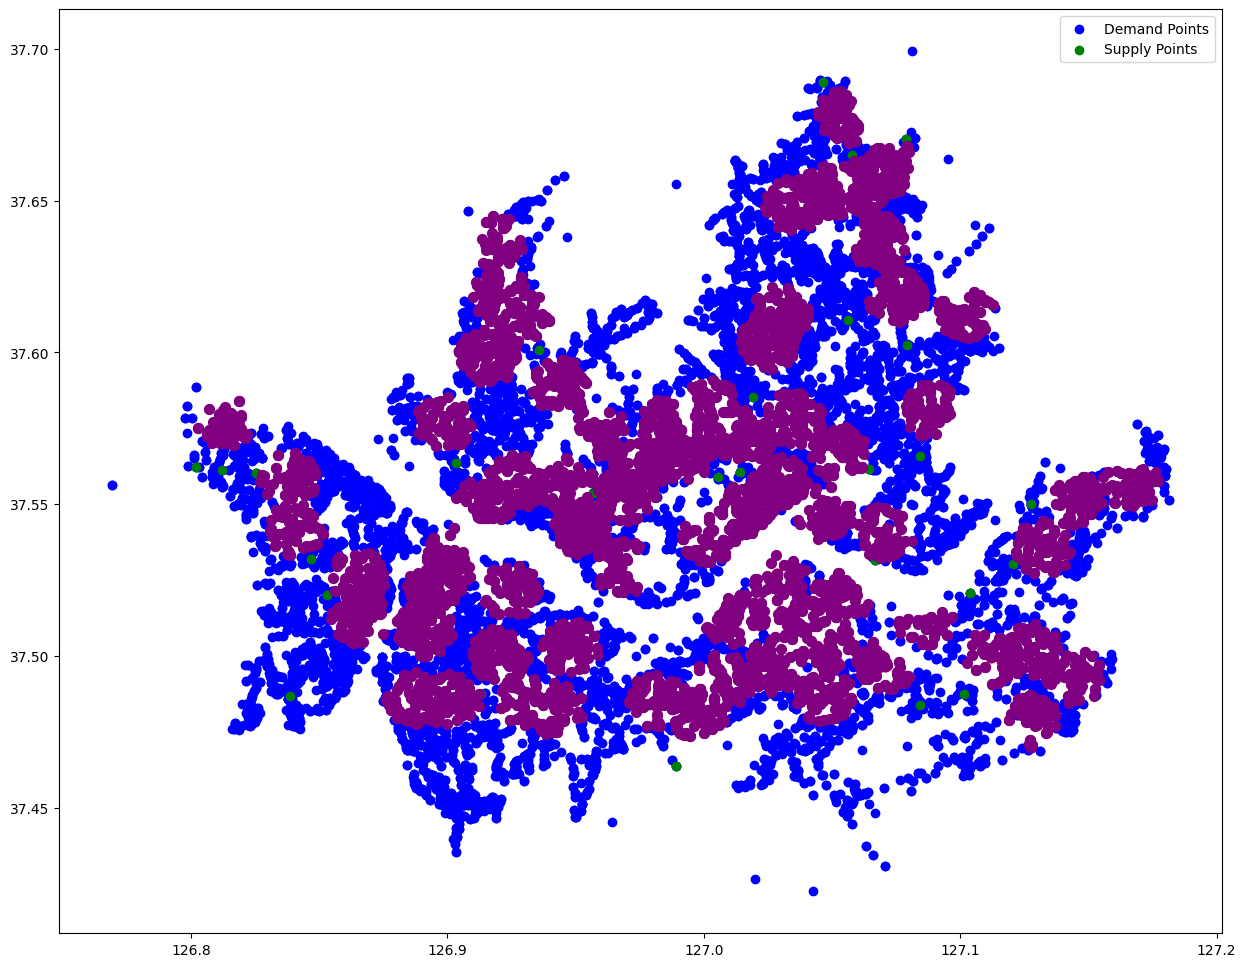

In [ ]:
import matplotlib.pyplot as plt

def plot_points(df_demand, df_supply, selected_supply, coverage):
    plt.figure(figsize=(15, 12))
    # Plot demand points
    plt.scatter(df_demand['x'], df_demand['y'], c='blue', label='Demand Points')

    # Plot supply points
    plt.scatter(df_supply['x'], df_supply['y'], c='green', label='Supply Points')

    # Plot selected supply points and coverage circles
    for idx in selected_supply.index:

        x = selected_supply.loc[idx,'x']
        y = selected_supply.loc[idx,'y']

        # Selected supply point as red dot
        plt.scatter(x,y,c="red", s=60)  # Decrease size

        covered_demands_x = [df_demand.loc[i,'x'] for i in coverage[idx]]
        covered_demands_y = [df_demand.loc[i,'y'] for i in coverage[idx]]

        # Highlight covered demand points (change color to purple)
        if len(covered_demands_x) > 0:
            plt.scatter(covered_demands_x ,covered_demands_y,c="purple", s=50)  # Increase size


plot_points(df_demand=concatenated_df,
            df_supply=supply_rain,
            selected_supply=result,
            coverage=coverage)

plt.legend(loc='best')  # Place legend at 'best' location
plt.show()

In [ ]:
full_name_list = result['name'].tolist()
print(full_name_list)

['강남', '강동', '거여', '건대입구', '공덕', '구로디지털단지', '구파발', '금호', '길음', '남구로', '노원', '답십리', '당산', '독립문', '동묘앞', '디지털미디어시티', '뚝섬', '매봉', '명일', '목동', '미아사거리', '발산', '방배', '방화', '보라매', '봉천', '불광', '사가정', '상계', '상도', '상일동', '서울역', '서초', '선릉', '송파', '수락산', '시청', '신내', '신도림', '신림', '신용산', '쌍문', '안국', '압구정', '양천구청', '여의도', '연신내', '영등포구청', '오금', '을지로3가', '응암', '이대', '이수', '잠실새내', '잠원', '장지', '제기동', '창동', '청담', '태릉입구', '하계', '학동', '학여울', '한강진', '합정', '행당', '혜화', '홍대입구', '홍제', '화곡']
